# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [52]:
data = pd.read_csv('./raw_data/retail_train.csv')
item_features = pd.read_csv('./raw_data/product.csv')
user_features = pd.read_csv('./raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [53]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [54]:
recommender = MainRecommender(data_train_lvl_1, item_features)

In [ ]:
recommender.get_als_recommendations(2375, N=200)

In [ ]:
recommender.get_own_recommendations(2375, N=200)

In [ ]:
recommender.get_similar_items_recommendation(2375, N=200)

In [ ]:
recommender.get_similar_users_recommendation(2375, N=200)

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [199]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [200]:
np.setdiff1d(result_lvl_1['user_id'], data_train_lvl_1['user_id']).tolist()

[296, 1813, 1984]

In [201]:
result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(data_train_lvl_1['user_id'].unique())]

In [202]:
result_lvl_1['own_recs'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, 200))
result_lvl_1['own_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['own_recs'], row['actual'], k=200), axis=1)
result_lvl_1['als_recs'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 200))
result_lvl_1['als_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['als_recs'], row['actual'], k=200), axis=1)

In [203]:
result_lvl_1['similar_recs'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, filter_ctm=False, N=200))
result_lvl_1['similar_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['similar_recs'], row['actual'], k=200), axis=1)

In [14]:
print(f"Mean recall of own recommendations: {result_lvl_1['own_recall'].mean()}")
print(f"Mean recall of ALS recommendations: {result_lvl_1['als_recall'].mean()}")
print(f"Mean recall of similar recommendations: {result_lvl_1['similar_recall'].mean()}")

Mean recall of own recommendations: 0.13537278412833242
Mean recall of ALS recommendations: 0.11004735709886966
Mean recall of similar recommendations: 0.09263444553443605


Лучший результат получился при рекомендации тех товаров, которые покупал пользователь.

In [15]:
k = [20, 50, 100, 200, 500]
def get_recalls(k):
    result_lvl_1['own_recs'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, k))
    result_lvl_1['own_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['own_recs'], row['actual'], k=k), axis=1)
    own_recall = result_lvl_1['own_recall'].mean()
    
    result_lvl_1['als_recs'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, k))
    result_lvl_1['als_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['als_recs'], row['actual'], k=k), axis=1)
    als_recall = result_lvl_1['als_recall'].mean()
    
    result_lvl_1['similar_recs'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, filter_ctm=False, N=k))
    result_lvl_1['similar_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['similar_recs'], row['actual'], k=k), axis=1)
    sim_recall = result_lvl_1['similar_recall'].mean()
    
    return own_recall, als_recall, sim_recall

In [16]:
own_recs = []
als_recs = []
sim_recs = []
for n in k:
    o, a, s = get_recalls(n)
    own_recs.append(o)
    als_recs.append(a)
    sim_recs.append(s)

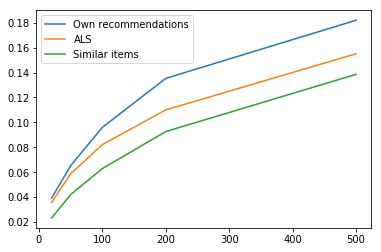

In [17]:
plt.plot(k, own_recs, label="Own recommendations")
plt.plot(k, als_recs, label="ALS")
plt.plot(k, sim_recs, label="Similar items")
plt.legend()

Исходя только из графика чем больше значение к - тем лучше. Но на деле 500 считается слишком долго, поэтому я выбрал бы 200.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [5]:
N = 200

In [55]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))

In [56]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1  # фиктивная пересенная

users_lvl_2.head(4)

,user_id,item_id,drop
0,2070,1105426,1
0,2070,1097350,1
0,2070,879194,1
0,2070,948640,1


In [57]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('drop', axis=1, inplace=True)

In [58]:
targets_lvl_2.head()

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0
2,2070,879194,0.0
3,2070,948640,0.0
4,2070,928263,0.0


**Для юзеров - средний чек и среднее число покупок в неделю (фактов покупок)**

In [59]:
data_train_lvl_2['price'] = data_train_lvl_2['sales_value'] / (np.maximum(data_train_lvl_2['quantity'], 1))

In [60]:
basket_mean_price = data_train_lvl_2.groupby(['user_id', 'basket_id'])['sales_value'].mean()

In [61]:
user_backet_mean_price = basket_mean_price.groupby('user_id').mean()

In [62]:
user_backet_mean_price

user_id
1        3.383393
2        3.085542
4        4.588189
6        2.980156
7        2.199049
          ...    
2496     2.517956
2497     3.995627
2498     4.639623
2499     3.022544
2500    12.553207
Name: sales_value, Length: 2154, dtype: float64

In [63]:
user_features = user_features.merge(user_backet_mean_price, on='user_id', how='left')

In [64]:
user_features = user_features.rename(columns={'sales_value': 'mean_basket'})

In [65]:
user_features

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,mean_basket
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,3.383393
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2.199049
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,2.869953
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,19.182598
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,3.613333
...,...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494,5.033548
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496,2.517956
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497,3.995627
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498,4.639623


In [66]:
baskets_per_week = data_train_lvl_2.groupby(['user_id', 'week_no'])['basket_id'].count()

In [67]:
user_baskets_per_week_mean = baskets_per_week.groupby('user_id').mean()

In [68]:
user_baskets_per_week_mean

user_id
1       22.166667
2       25.333333
4        8.000000
6       17.000000
7       22.500000
          ...    
2496    35.500000
2497    26.666667
2498    11.800000
2499    19.500000
2500    19.200000
Name: basket_id, Length: 2154, dtype: float64

In [69]:
user_features = user_features.merge(user_baskets_per_week_mean, on='user_id', how='left')

In [70]:
user_features = user_features.rename(columns={'basket_id': 'mean_baskets_weekly'})

In [71]:
user_features

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,mean_basket,mean_baskets_weekly
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,3.383393,22.166667
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2.199049,22.500000
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,2.869953,30.750000
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,19.182598,29.500000
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,3.613333,3.500000
...,...,...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494,5.033548,47.000000
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496,2.517956,35.500000
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497,3.995627,26.666667
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498,4.639623,11.800000


**Для товаров - средняя цена по категориям и среднее количество покупок в неделю (только фактов покупок и только по тем неделям, когда товар покупался)**

In [72]:
prices = data_train_lvl_2.groupby(['item_id'])['price'].mean()

In [73]:
item_features = item_features.merge(prices, on='item_id', how='left')

In [74]:
item_features

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,NaN
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,NaN
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,NaN
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,NaN
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,NaN
...,...,...,...,...,...,...,...,...
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,NaN
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,,NaN
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,,NaN
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,,NaN


In [75]:
commodity = item_features.groupby(['commodity_desc'])['price'].mean()

In [76]:
item_features = item_features.merge(commodity, on='commodity_desc', how='left')

In [77]:
item_features = item_features.rename(columns={'sales_value_x': 'price', 'sales_value_y': 'avg_commodity_price'})

In [78]:
items_weekly = data_train_lvl_2.groupby(['item_id', 'week_no'])['sales_value'].count()

In [79]:
items_weekly_mean = items_weekly.groupby(['item_id']).mean()

In [80]:
items_weekly_mean

item_id
28116       1.0
28117       1.0
28143       1.0
28186       1.0
28304       1.0
           ... 
17381856    1.0
17382205    1.0
17383227    1.0
17827644    1.0
17829232    2.0
Name: sales_value, Length: 27649, dtype: float64

In [81]:
item_features = item_features.merge(items_weekly_mean, on='item_id', how='left')

In [82]:
item_features = item_features.rename(columns={'sales_value': 'weekly_mean'})

**Фичи пары пользователь - товар - средняя сумма покупок пользователя в каждой категории и отношение среднего количества покупок в категории одного пользователя к общему среднему**

In [83]:
data_train_lvl_2 = data_train_lvl_2.merge(item_features[['item_id', 'commodity_desc']], on='item_id', how='left')

In [84]:
user_commodity_total = data_train_lvl_2.groupby(['user_id', 'commodity_desc'])['sales_value'].mean()

In [85]:
data_train_lvl_2 = data_train_lvl_2.merge(user_commodity_total, on=['user_id', 'commodity_desc'], how='left')

In [86]:
data_train_lvl_2 = data_train_lvl_2.rename(columns={'sales_value_y':'avg_commodity_val'})

In [87]:
user_commodity_cnt_weekly = data_train_lvl_2.groupby(['user_id', 'commodity_desc', 'week_no'])['item_id'].count()

In [88]:
user_commodity_mean_weekly = user_commodity_cnt_weekly.groupby(['user_id', 'commodity_desc']).mean()

In [89]:
overall_commodity_mean = user_commodity_cnt_weekly.groupby(['commodity_desc', 'week_no']).mean()

In [90]:
overall_commodity_mean_weekly = overall_commodity_mean.groupby(['commodity_desc']).mean()

In [91]:
data_train_lvl_2 = data_train_lvl_2.merge(user_commodity_mean_weekly, on=['user_id', 'commodity_desc'], how='left').rename(columns={'item_id_y': 'user_commodity_weekly'})

In [92]:
data_train_lvl_2 = data_train_lvl_2.merge(overall_commodity_mean_weekly, on=['commodity_desc'], how='left').rename(columns={'item_id': 'commodity_weekly', 'item_id_x': 'item_id'})

In [93]:
data_train_lvl_2['user_commodity_comp'] = data_train_lvl_2['user_commodity_weekly'] / data_train_lvl_2['commodity_weekly']

In [94]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(data_train_lvl_2, on=['user_id', 'item_id'], how='left')

In [95]:
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc_x,sub_commodity_desc,curr_size_of_product,price_x,...,trans_time,week_no,coupon_disc,coupon_match_disc,price,commodity_desc_y,avg_commodity_val,user_commodity_weekly,commodity_weekly,user_commodity_comp
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,3.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,10.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,7.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [97]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc_x',
 'sub_commodity_desc',
 'curr_size_of_product',
 'price_x',
 'price_y',
 'weekly_mean',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'mean_basket',
 'mean_baskets_weekly',
 'basket_id',
 'day',
 'quantity',
 'sales_value_x',
 'store_id',
 'retail_disc',
 'trans_time',
 'week_no',
 'coupon_disc',
 'coupon_match_disc',
 'price',
 'commodity_desc_y',
 'avg_commodity_val',
 'user_commodity_weekly',
 'commodity_weekly',
 'user_commodity_comp']

In [98]:
%%time

lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

C:\Users\Viktor\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Viktor\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Viktor\Anaconda3\lib\site-packages\lightgbm\basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Wall time: 5.66 s


In [99]:
targets_lvl_2['preds'] = train_preds

In [100]:
lgb_candidates = targets_lvl_2.groupby('user_id').head(5).groupby('user_id')['item_id'].unique().reset_index()

In [101]:
lgb_candidates.head()

,user_id,item_id
0,1,"[856942, 9297615]"
1,2,"[911974, 1076580, 1103898, 5567582, 1056620]"
2,4,"[6391541, 1052294, 891423, 936470, 1137010]"
3,6,"[13003092, 972416, 995598, 923600, 1138596]"
4,7,"[998519, 894360, 7147142, 9338009, 896666]"


In [103]:
valid_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})
valid_lvl_2 = valid_lvl_2.merge(lgb_candidates, on='user_id', how='left')

In [110]:
valid_lvl_2[valid_lvl_2['lgb_candidates'].notna()].apply(lambda row: precision_at_k(row['lgb_candidates'], row['actual'], k=5), axis=1).mean()

0.20145343777197416

In [111]:
data_train_lvl_1_2 = data[data['week_no'] < data['week_no'].max() - val_lvl_2_size_weeks]

In [113]:
result_als = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_als.columns=['user_id', 'actual']
result_als.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [119]:
np.setdiff1d(result_als['user_id'], data_train_lvl_1['user_id']).tolist()

[1984, 2259]

In [120]:
result_als = result_als[result_als['user_id'].isin(data_train_lvl_1['user_id'].unique())]

In [121]:
result_als['als_recs'] = result_als['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 200))

In [123]:
result_als[result_als['als_recs'].notna()].apply(lambda row: precision_at_k(row['als_recs'], row['actual'], k=5), axis=1).mean()

0.10843137254901901

Итого у меня получилось, что при использовании 2х уровненовой модели с делением датасета на 3 части результат получился в 2 раза лучше, чем при использовании одного ALS с делением датасета на 2 части.

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов**
- **Все товары из разных категорий** (категория - department)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)